In [39]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
# for data load
import os

# for reading and processing images
#import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow.keras.backend as K

In [40]:
data_dir = "ds"
internal_directory = os.listdir(data_dir)
print(internal_directory)

['images', 'mask']


In [44]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [45]:
print(np.shape(X_train))
print(np.shape(y_train))

(8, 96, 96, 3)
(8, 96, 96, 3, 1)


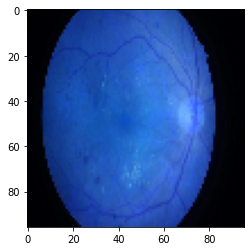

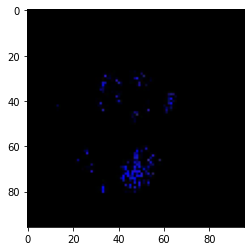

In [46]:
ix = 0
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.squeeze(y_train[ix]))
plt.show()

In [47]:

# We require convolutional blocks of different constitution to build a model with UNet architecture
# For this we will combine convolution (c) and pool (p) operations
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p


def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1): # UNet has skip-connections
    us = keras.layers.UpSampling2D((2, 2))(x) # upsampling (us)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat) # concat is input here
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [48]:
def UNet():
    """
    Represents a model with UNet-type architecture

    """
    f = [16, 32, 64, 128, 256]  # feature maps
    inputs = keras.layers.Input((96, 96, 3))

    # Downsampling part
    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 -> 64
    c2, p2 = down_block(p1, f[1])  # 64 -> 32
    c3, p3 = down_block(p2, f[2])  # 32 -> 16
    c4, p4 = down_block(p3, f[3])  # 16-> 8

    # Middle (Bottleneck) part
    bn = bottleneck(p4, f[4])

    # Upsampling part
    u1 = up_block(bn, c4, f[3])  # 8 -> 16
    u2 = up_block(u1, c3, f[2])  # 16 -> 32
    u3 = up_block(u2, c2, f[1])  # 32 -> 64
    u4 = up_block(u3, c1, f[0])  # 64 -> 128

    # Final layer
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)

    # Model overall
    model = keras.models.Model(inputs, outputs)
    return model

In [49]:
# Dice coefficient and loss funcion definition
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

In [52]:
# Model compiling and summing up 
model = UNet()
# !!! Creating a model compilation with Dice loss function has some issues in our case
# !!! dice_loss = dice_loss(y_true, y_pred)
# !!! model.compile(optimizer="sgd", loss="dice_loss", metrics=["dice_coef"]) # not working
# !!! So here used some common compile parameters
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

NameError: name 'image_size' is not defined

In [51]:
model.fit(X_train,
          validation_data=X_valid,
     
          epochs=5)

NameError: name 'model' is not defined